In [58]:
import math
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("KMeans")
sc = SparkContext(conf=conf)

In [59]:
c1 = sc.textFile("c1.txt")
c2 = sc.textFile("c2.txt")
data = sc.textFile("data.txt")

iterations = 20

mapper_c1_c2_data 將DATA分割成數值 

In [60]:
def mapper_c1_c2_data(c):
    point = c.split(" ")
    return point

mapper_Euclidean_cost 及 mapper_Manhattan_cost 為計算兩種不同公式的cost <br>
傳入經過卡式積的point = ((p, index), c) <br>
對每個p計算他與所有不同centroid點的距離 <br>
最後回傳 p, c 與 cost

In [61]:
def mapper_Euclidean_cost(point):
    costs = 0
    (p,index),c = point
    for i in range(len(p)):
        costs = costs + ( (float(p[i]) - float(c[i]))**2 )
    return (tuple((tuple(p),index)), (c, costs))

In [62]:
def mapper_Manhattan_cost(point):
    costs = 0
    (p,index),c = point
    for i in range(len(p)):
        costs = costs + ( abs(float(p[i]) - float(c[i])))
    return (tuple((tuple(p),index)), (c, costs))

mapper_newCentroid 為計算每個集群中的新centroid <br>
對每個group後的centroid中的每個維度進行平均 <br>
得到新的centroid

In [63]:
# (c1, (p1, p2 ...)), (c2, (p1, p2 ...)) => (c1,c2...)
def mapper_newCentroid(centroid):
    cen = []
    count = 1
    for j in centroid[1]:
        for i in range(len(j)):
            if(count == 1):
                cen.append(float(j[i])/len(centroid[1]))
            else:
                cen[i]+=float(j[i])/len(centroid[1])
        count+=1
    return cen

reducerMin 為 回傳每個point與其最相近的centroid

In [64]:
def reducerMin(x,y):
    if(x[1] < y[1]):
        return x
    else:
        return y

In [65]:
# 10 * 58
c1 = c1.map(mapper_c1_c2_data)
# 10 * 58
c2 = c2.map(mapper_c1_c2_data)
# 4601 * 58
data = data.map(mapper_c1_c2_data).zipWithIndex()

#  Euclidean_distance/C1

首先將data與centroid做卡式積，得到所有data, centroid的pair <br>
計算cost並以最小的cost來分群 <br>
將新的分群結果以centroid為key 進行groupby，並且計算新的centroid <br>
其餘的c2及Manhattan 也是相同作法

In [45]:
costs_Euclidean_c1 = []
import time
from operator import add
for i in range(iterations):
    T0 = time.time()

    allPair = data.cartesian(c1)    
    euclidean_costs = allPair.map(mapper_Euclidean_cost).reduceByKey(reducerMin)
    c1 = euclidean_costs.map(lambda x:(tuple(x[1][0]),x[0][0])).groupByKey().map(mapper_newCentroid)
    
#     only for graph
    costs_Euclidean_c1.append(euclidean_costs.map(lambda x:(x[1][1])).reduce(add))

    T1 = time.time()
    print(T1-T0)

8.480737924575806
12.977973699569702
12.993813753128052
13.334196090698242
12.921977758407593
12.942640781402588
12.917188167572021
13.394073486328125
12.975934743881226
13.066440343856812
13.129003524780273
13.17427921295166
13.04583740234375
13.039581060409546
13.000791788101196
13.10651183128357
13.12788701057434
12.97199273109436
13.098744630813599
13.024967432022095


In [46]:
for i in costs_Euclidean_c1:
    print(i)

623660345.3064234
509862908.29754597
485480681.87200826
463997011.6850107
460969266.572994
460537847.98277
460313099.6535423
460003523.88940674
459570539.3177352
459021103.34229004
458490656.19198066
457944232.5879741
457558005.19867957
457290136.35230315
457050555.0595638
456892235.61535734
456703630.73703563
456404203.01897687
456177800.5419951
455986871.0273484


In [47]:
print(  abs(costs_Euclidean_c1[iterations-1]-costs_Euclidean_c1[0])/costs_Euclidean_c1[0]*100,"%" )

26.885383292518288 %


In [48]:
c1_eu_dis = c1.collect()
all = []
for i in range(len(c1_eu_dis)):
    dis=[]
    for j in range(len(c1_eu_dis)):
        distance = 0
        for k in range(len(c1_eu_dis[i])):
            distance = distance + ( (c1_eu_dis[i][k] - c1_eu_dis[j][k])**2 )
        dis.append(round(distance**0.5,3))
    all.append(dis)

from pandas import DataFrame
df = DataFrame (all)
print (df)
df.to_csv("Euclidean_c1_Euclidean.csv")

          0         1         2         3         4         5         6  \
0     0.000   646.931  1615.852   167.150    99.546  1038.827   346.719   
1   646.931     0.000   975.320   814.076   746.336   412.076   307.669   
2  1615.852   975.320     0.000  1782.203  1715.253   669.890  1282.771   
3   167.150   814.076  1782.203     0.000    67.912  1204.078   512.612   
4    99.546   746.336  1715.253    67.912     0.000  1136.327   444.731   
5  1038.827   412.076   669.890  1204.078  1136.327     0.000   692.158   
6   346.719   307.669  1282.771   512.612   444.731   692.158     0.000   
7   220.902   867.823  1835.640    53.790   121.634  1257.450   566.202   
8   142.439   504.634  1474.945   309.506   241.730   897.659   205.750   
9  3836.907  3195.924  2294.580  4002.689  3934.872  2798.801  3490.259   

          7         8         9  
0   220.902   142.439  3836.907  
1   867.823   504.634  3195.924  
2  1835.640  1474.945  2294.580  
3    53.790   309.506  4002.689  
4   

In [49]:
all = []
for i in range(len(c1_eu_dis)):
    dis=[]
    for j in range(len(c1_eu_dis)):
        distance = 0
        for k in range(len(c1_eu_dis[i])):
            distance = distance + abs(c1_eu_dis[i][k] - c1_eu_dis[j][k])
        dis.append(round(distance,3))
    all.append(dis)

from pandas import DataFrame
df = DataFrame (all)
print (df)
df.to_csv("Euclidean_c1_Manhattan.csv")

          0         1         2         3         4         5         6  \
0     0.000   779.397  2102.865   204.523   125.597  1100.833   374.890   
1   779.397     0.000  1327.584   983.020   904.370   490.928   406.701   
2  2102.865  1327.584     0.000  2306.380  2227.556  1005.293  1731.064   
3   204.523   983.020  2306.380     0.000    79.402  1303.896   577.402   
4   125.597   904.370  2227.556    79.402     0.000  1225.352   499.158   
5  1100.833   490.928  1005.293  1303.896  1225.352     0.000   728.924   
6   374.890   406.701  1731.064   577.402   499.158   728.924     0.000   
7   272.935  1050.916  2374.545    69.590   147.866  1372.092   645.770   
8   171.365   609.749  1934.087   375.248   296.255   935.885   212.181   
9  4170.305  3396.420  2513.423  4372.789  4294.953  3072.889  3797.899   

          7         8         9  
0   272.935   171.365  4170.305  
1  1050.916   609.749  3396.420  
2  2374.545  1934.087  2513.423  
3    69.590   375.248  4372.789  
4   

#  Euclidean_distance/C2

In [50]:
costs_Euclidean_c2 = []
import time
for i in range(iterations):
    T0 = time.time()

    allPair = data.cartesian(c2)    
    euclidean_costs = allPair.map(mapper_Euclidean_cost).reduceByKey(reducerMin)
    costs_Euclidean_c2.append(euclidean_costs.map(lambda x:(0,x[1][1])).reduceByKey(lambda x,y:x+y).collect()[0][1])
    c2 = euclidean_costs.map(lambda x:(tuple(x[1][0]),x[0][0])).groupByKey().map(mapper_newCentroid)
    
    T1 = time.time()
    print(T1-T0)

8.815823078155518
13.268280029296875
13.218432903289795
13.271655082702637
13.274410486221313
13.24169659614563
13.359541893005371
13.301944494247437
13.370165586471558
13.286251306533813
13.451608180999756
13.35638689994812
13.315484762191772
13.232831716537476
13.330370903015137
13.194939613342285
13.19839334487915
13.279178857803345
13.360661268234253
13.450348615646362


In [51]:
for i in costs_Euclidean_c2:
    print(i)

438747790.027918
249803933.62600282
194494814.4063139
169804841.45154336
156295748.80627602
149094208.10896608
142508531.61961603
132303869.40653005
117170969.83719078
108547377.17857014
102237203.31799622
98278015.74975733
95630226.12177442
93793314.05119286
92377131.96821104
91541606.25423908
91045573.83042423
90752240.10140836
90470170.18122776
90216416.17563143


In [52]:
print(  abs(costs_Euclidean_c2[iterations-1]-costs_Euclidean_c2[0])/costs_Euclidean_c2[0]*100,"%" )

79.437750291599 %


In [53]:
c2_eu_dis = c2.collect()
all = []
for i in range(len(c2_eu_dis)):
    dis=[]
    for j in range(len(c2_eu_dis)):
        distance = 0
        for k in range(len(c2_eu_dis[i])):
            distance = distance + ( (c2_eu_dis[i][k] - c2_eu_dis[j][k])**2 )
        dis.append(round(distance**0.5,3))
    all.append(dis)

from pandas import DataFrame
df = DataFrame (all)
print (df)
df.to_csv("Euclidean_c2_Euclidean.csv")

           0          1          2          3          4          5         6  \
0      0.000   1100.859   2105.443    402.891   3169.004   1924.624  9045.320   
1   1100.859      0.000   1010.198    698.488   2085.461   1182.864  7957.776   
2   2105.443   1010.198      0.000   1702.793   1080.535   1313.327  6947.821   
3    402.891    698.488   1702.793      0.000   2768.608   1615.788  8644.807   
4   3169.004   2085.461   1080.535   2768.608      0.000   2153.771  5876.330   
5   1924.624   1182.864   1313.327   1615.788   2153.771      0.000  7718.222   
6   9045.320   7957.776   6947.821   8644.807   5876.330   7718.222     0.000   
7  15760.122  14682.451  13674.708  15362.418  12597.040  14455.119  6743.884   
8  14110.834  13208.003  12508.957  13786.484  11938.376  12233.960  9545.879   
9   5567.685   4492.458   3488.159   5169.937   2407.919   4404.563  3494.222   

           7          8          9  
0  15760.122  14110.834   5567.685  
1  14682.451  13208.003   4492.458

In [54]:
all = []
for i in range(len(c2_eu_dis)):
    dis=[]
    for j in range(len(c2_eu_dis)):
        distance = 0
        for k in range(len(c2_eu_dis[i])):
            distance = distance + abs(c2_eu_dis[i][k] - c2_eu_dis[j][k])
        dis.append(round(distance,3))
    all.append(dis)

from pandas import DataFrame
df = DataFrame (all)
print (df)
df.to_csv("Euclidean_c2_Manhattan.csv")

           0          1          2          3          4          5  \
0      0.000   1311.039   2369.412    471.266   3349.657   3088.054   
1   1311.039      0.000   1068.940    840.723   2137.788   1781.823   
2   2369.412   1068.940      0.000   1901.209   1176.450   2162.802   
3    471.266    840.723   1901.209      0.000   2883.735   2619.811   
4   3349.657   2137.788   1176.450   2883.735      0.000   3337.746   
5   3088.054   1781.823   2162.802   2619.811   3337.746      0.000   
6   9533.171   8228.355   7168.733   9065.404   6190.679   8896.389   
7  15772.615  14909.170  13950.576  15434.460  12776.883  16105.347   
8  20215.646  18912.605  17851.807  19748.936  16873.244  17509.903   
9   5604.200   4696.975   3737.707   5221.253   2564.171   5893.070   

           6          7          8          9  
0   9533.171  15772.615  20215.646   5604.200  
1   8228.355  14909.170  18912.605   4696.975  
2   7168.733  13950.576  17851.807   3737.707  
3   9065.404  15434.460  1

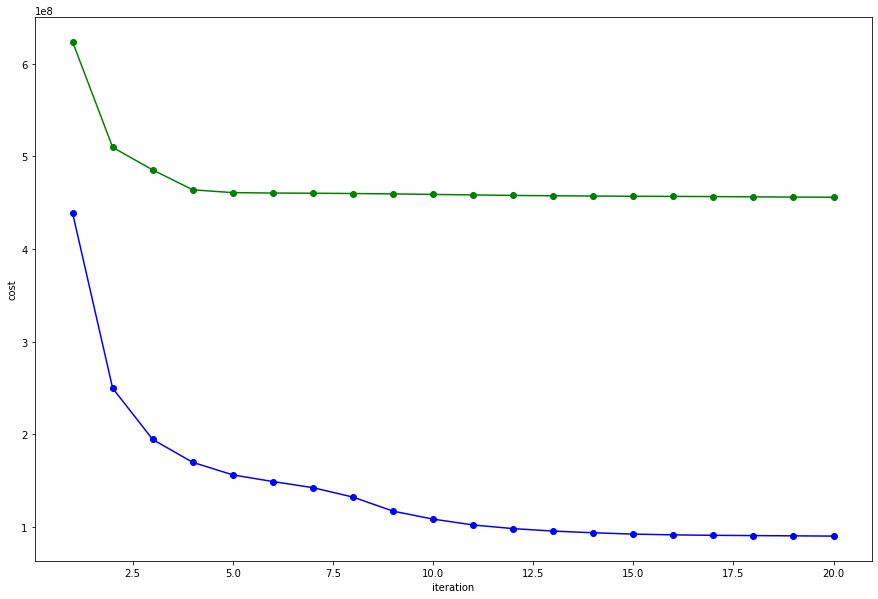

In [55]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
x = range(1,iterations+1)
plt.figure(figsize=(15,10),linewidth = 2)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.plot(x,costs_Euclidean_c1,'-o',color='green')
plt.plot(x,costs_Euclidean_c2,'-o',color='blue')

plt.show()

In [56]:
# 10 * 58
c1 = c1.map(mapper_c1_c2_data)
# 10 * 58
c2 = c2.map(mapper_c1_c2_data)
# 4601 * 58
data = data.map(mapper_c1_c2_data).zipWithIndex()

#  Manhattan_distance/C1

In [66]:
costs_Manhattan_c1 = []
import time
for i in range(iterations):
    T0 = time.time()

    allPair = data.cartesian(c1)    
    manhattan_costs = allPair.map(mapper_Manhattan_cost).reduceByKey(reducerMin)
    costs_Manhattan_c1.append(manhattan_costs.map(lambda x:(0,x[1][1])).reduceByKey(lambda x,y:x+y).collect()[0][1])
    c1 = manhattan_costs.map(lambda x:(tuple(x[1][0]),x[0][0])).groupByKey().map(mapper_newCentroid)
    
    T1 = time.time()
    print(T1-T0)

8.709665775299072
13.348218202590942
13.299754619598389
13.190796136856079
13.286919116973877
13.316881895065308
13.296597480773926
13.22067928314209
13.415807723999023
13.418843269348145
13.475300550460815
13.400506258010864
13.329217433929443
13.32528042793274
13.256082773208618
13.370865106582642
13.330478191375732
13.24976658821106
13.375738620758057
13.50118374824524


In [67]:
c1_ma_dis = c1.collect()
all = []
for i in range(len(c1_ma_dis)):
    dis=[]
    for j in range(len(c1_ma_dis)):
        distance = 0
        for k in range(len(c1_ma_dis[i])):
            distance = distance + ( (c1_ma_dis[i][k] - c1_ma_dis[j][k])**2 )
        dis.append(round(distance**0.5,3))
    all.append(dis)

from pandas import DataFrame
df = DataFrame (all)
print (df)
df.to_csv("Manhattan_c1_Euclidean.csv")

           0         1         2          3          4          5         6  \
0      0.000   685.155  1407.269    236.438    146.795    272.536  2898.578   
1    685.155     0.000   724.882    921.176    831.594    415.770  2214.964   
2   1407.269   724.882     0.000   1641.914   1552.742   1135.224  1491.357   
3    236.438   921.176  1641.914      0.000     89.666    506.763  3133.245   
4    146.795   831.594  1552.742     89.666      0.000    417.519  3044.096   
5    272.536   415.770  1135.224    506.763    417.519      0.000  2626.579   
6   2898.578  2214.964  1491.357   3133.245   3044.096   2626.579     0.000   
7    249.613   531.301  1249.906    457.816    375.438    221.316  2732.841   
8   1391.422   828.932   709.408   1613.363   1529.086   1170.533  1812.455   
9  10626.352  9943.770  9236.840  10862.753  10773.141  10359.504  7767.946   

           7         8          9  
0    249.613  1391.422  10626.352  
1    531.301   828.932   9943.770  
2   1249.906   709.408

In [68]:
all = []
for i in range(len(c1_ma_dis)):
    dis=[]
    for j in range(len(c1_ma_dis)):
        distance = 0
        for k in range(len(c1_ma_dis[i])):
            distance = distance + abs(c1_ma_dis[i][k] - c1_ma_dis[j][k])
        dis.append(round(distance,3))
    all.append(dis)

from pandas import DataFrame
df = DataFrame (all)
print (df)
df.to_csv("Manhattan_c1_Manhattan.csv")

           0          1          2          3          4          5         6  \
0      0.000    775.805   1500.840    287.351    177.255    278.003  3104.116   
1    775.805      0.000    732.704   1061.783    952.467    499.653  2336.037   
2   1500.840    732.704      0.000   1786.572   1677.155   1224.764  1605.270   
3    287.351   1061.783   1786.572      0.000    110.470    563.475  3388.744   
4    177.255    952.467   1677.155    110.470      0.000    454.244  3279.855   
5    278.003    499.653   1224.764    563.475    454.244      0.000  2828.265   
6   3104.116   2336.037   1605.270   3388.744   3279.855   2828.265     0.000   
7    382.469    652.125   1376.942    667.483    558.134    335.664  2777.742   
8   2028.739   1255.347   1006.368   2314.427   2204.800   1753.198  2380.461   
9  12695.389  11924.080  11196.787  12978.891  12870.996  12419.434  9597.441   

           7          8          9  
0    382.469   2028.739  12695.389  
1    652.125   1255.347  11924.080

In [69]:
for i in costs_Manhattan_c1:
    print(i)

550117.1420000045
464661.07277264463
471200.04907668446
484160.6943550472
489251.7236234728
487564.74176785816
483404.05632034066
475365.3418409853
474924.05018140585
457233.6401358033
447495.09098985215
451004.3064630867
451222.0932561685
451973.8467044291
451585.35588920774
452756.645432641
452893.7923509914
450382.23409588065
450023.9688637897
448929.47449886805


In [70]:
print(  abs(costs_Manhattan_c1[iterations-1]-costs_Manhattan_c1[0])/costs_Manhattan_c1[0]*100,"%" )

18.393840107083165 %


#  Manhattan_distance/C2

In [71]:
costs_Manhattan_c2 = []
import time
for i in range(iterations):
    T0 = time.time()

    allPair = data.cartesian(c2)    
    manhattan_costs = allPair.map(mapper_Manhattan_cost).reduceByKey(reducerMin)
    costs_Manhattan_c2.append(manhattan_costs.map(lambda x:(0,x[1][1])).reduceByKey(lambda x,y:x+y).collect()[0][1])
    c2 = manhattan_costs.map(lambda x:(tuple(x[1][0]),x[0][0])).groupByKey().map(mapper_newCentroid)
    
    T1 = time.time()
    print(T1-T0)

9.025771141052246
13.336397886276245
13.348089456558228
13.571536779403687
13.486557245254517
13.332107305526733
13.240761518478394
13.306808233261108
13.333429336547852
13.337814807891846
13.444000482559204
13.413692712783813
13.31283974647522
13.482855319976807
13.305006504058838
13.226149797439575
13.240932941436768
13.2150239944458
13.581934690475464
13.325326442718506


In [72]:
for i in costs_Manhattan_c2:
    print(i)

1433739.3099999938
1084488.7769648714
973431.7146620398
895934.592563068
865128.3352940795
845846.6470313452
827219.5827561244
803590.3456011058
756039.5172761241
717332.9025432301
694587.9252526833
684444.501996794
674574.7475478576
667409.4699160255
663556.6278214991
660162.7772287576
656041.322294709
653036.7540731634
651112.4262522662
649689.0131843559


In [73]:
print(  abs(costs_Manhattan_c2[iterations-1]-costs_Manhattan_c2[0])/costs_Manhattan_c2[0]*100,"%" )

54.68569434813371 %


In [74]:
c2_ma_dis = c2.collect()
all = []
for i in range(len(c2_ma_dis)):
    dis=[]
    for j in range(len(c2_ma_dis)):
        distance = 0
        for k in range(len(c2_ma_dis[i])):
            distance = distance + ( (c2_ma_dis[i][k] - c2_ma_dis[j][k])**2 )
        dis.append(round(distance**0.5,3))
    all.append(dis)

from pandas import DataFrame
df = DataFrame (all)
print (df)
df.to_csv("Manhattan_c2_Euclidean.csv")

           0          1          2          3          4          5         6  \
0      0.000    514.627   1571.243   1338.161   3022.661   2006.703  9032.333   
1    514.627      0.000   1081.379    827.841   2511.459   1637.729  8521.198   
2   1571.243   1081.379      0.000    566.551   1649.389    910.994  7588.405   
3   1338.161    827.841    566.551      0.000   1684.516   1405.109  7694.277   
4   3022.661   2511.459   1649.389   1684.516      0.000   2124.263  6009.820   
5   2006.703   1637.729    910.994   1405.109   2124.263      0.000  7742.628   
6   9032.333   8521.198   7588.405   7694.277   6009.820   7742.628     0.000   
7  15747.234  15239.877  14328.226  14412.057  12731.398  14474.554  6743.884   
8  14100.145  13684.607  12643.986  13125.351  12006.395  12167.794  9545.879   
9   5554.787   5047.516   4167.637   4219.761   2542.569   4452.972  3494.222   

           7          8          9  
0  15747.234  14100.145   5554.787  
1  15239.877  13684.607   5047.516

In [75]:
all = []
for i in range(len(c2_ma_dis)):
    dis=[]
    for j in range(len(c2_ma_dis)):
        distance = 0
        for k in range(len(c2_ma_dis[i])):
            distance = distance + abs(c2_ma_dis[i][k] - c2_ma_dis[j][k])
        dis.append(round(distance,3))
    all.append(dis)

from pandas import DataFrame
df = DataFrame (all)
print (df)
df.to_csv("Manhattan_c2_Manhattan.csv")

           0          1          2          3          4          5  \
0      0.000    602.955   2102.554   1430.209   3211.456   3281.488   
1    602.955      0.000   1500.825    833.430   2613.997   2682.569   
2   2102.554   1500.825      0.000    674.828   2062.251   1358.796   
3   1430.209    833.430    674.828      0.000   1784.512   1855.580   
4   3211.456   2613.997   2062.251   1784.512      0.000   3413.036   
5   3281.488   2682.569   1358.796   1855.580   3413.036      0.000   
6   9517.668   8918.813   7771.222   8090.510   6312.530   9116.025   
7  15757.691  15335.957  14980.056  14506.486  12922.931  16325.271   
8  20200.259  19602.263  18111.885  18775.121  16995.134  17521.518   
9   5588.854   5123.067   4768.923   4293.502   2710.057   6110.832   

           6          7          8          9  
0   9517.668  15757.691  20200.259   5588.854  
1   8918.813  15335.957  19602.263   5123.067  
2   7771.222  14980.056  18111.885   4768.923  
3   8090.510  14506.486  1

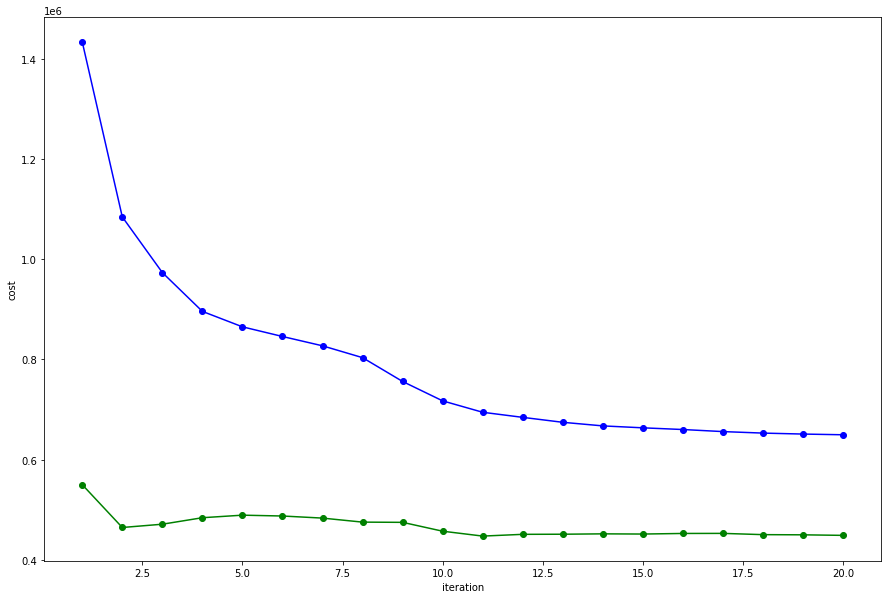

In [76]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
x = range(1,iterations+1)
plt.figure(figsize=(15,10),linewidth = 2)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.plot(x,costs_Manhattan_c1,'-o',color='green')
plt.plot(x,costs_Manhattan_c2,'-o',color='blue')

plt.show()

In [ ]:
sc.stop()